<a href="https://www.bigdatauniversity.com"><img src = "https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width = 300, align = "center"></a>

# Classifiers for Loan Payment Prediction
**Coursera / IBM Data Science / Machine Learning with Python / Final Assignment**  
Ginanjar Saputra, 4 February 2021

**Instructions:** In this project, you will complete a notebook where you will build a classifier to predict whether a loan case will be paid off or not. You load a historical dataset from previous loan applications, clean the data, and apply different classification algorithm on the data. You are expected to use the following algorithms to build your models:
- k-Nearest Neighbour
- Decision Tree
- Support Vector Machine
- Logistic Regression

The results is reported as the accuracy of each classifier, using the following metrics when these are applicable:
- Jaccard index
- F1-score
- LogLoss

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pydotplus

from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, jaccard_score, f1_score, log_loss

from io import StringIO

## Dataset

This dataset is about past loans. The [**loan_train.csv**](https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv) data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

- **loan_status**: Whether a loan is paid off on in collection
- **principal**: Basic principal loan amount
- **terms**: Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule
- **effective_date**: When the loan got originated and took effects
- **due_date**: Since it's one-time payoff schedule, each loan has one single due date
- **age**: Age of applicant
- **education**: Education of applicant
- **gender**: The gender of applicant

### Load Data from CSV File  

In [2]:
loan_file = 'https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv'
df = pd.read_csv(loan_file)
print(f'Shape: {df.shape[0]} rows, {df.shape[1]} columns')
df.head()

Shape: 346 rows, 10 columns


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      346 non-null    int64 
 1   Unnamed: 0.1    346 non-null    int64 
 2   loan_status     346 non-null    object
 3   Principal       346 non-null    int64 
 4   terms           346 non-null    int64 
 5   effective_date  346 non-null    object
 6   due_date        346 non-null    object
 7   age             346 non-null    int64 
 8   education       346 non-null    object
 9   Gender          346 non-null    object
dtypes: int64(5), object(5)
memory usage: 27.2+ KB


## Data Pre-processing and Visualization

### Remove irrelevant columns

In [4]:
df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


### Convert datetime objects

The fields `effective_date` and `due_date` will be converted to datetime objects.

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


### Visualize data

Let's plot some columns to understand the data better. First, see how many of each class is in the dataset:

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection.

#### Distribution of customers by basic principal loan amount

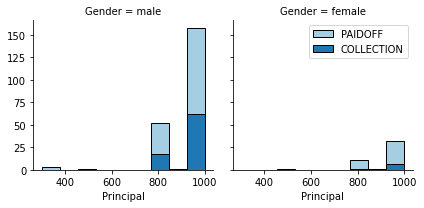

In [7]:
bins = np.linspace(df['Principal'].min(), df['Principal'].max(), 10)
g = sns.FacetGrid(
    df, col='Gender', hue='loan_status', palette='Paired', col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec='k')
g.axes[-1].legend()
plt.show()

#### Distribution of customers by age

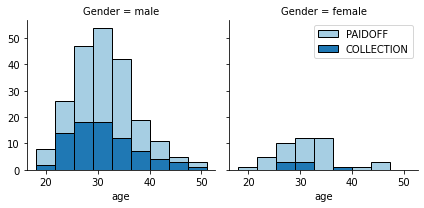

In [8]:
bins = np.linspace(df['age'].min(), df['age'].max(), 10)
g = sns.FacetGrid(
    df, col='Gender', hue='loan_status', palette='Paired', col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec='k')
g.axes[-1].legend()
plt.show()

#### The day of the week when people get the loan 

Get the day of the week from column `effective_date` (Monday = 0, Tuesday = 1, and so on).

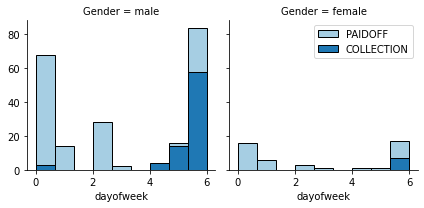

In [9]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df['dayofweek'].min(), df['dayofweek'].max(), 10)
g = sns.FacetGrid(
    df, col='Gender', hue='loan_status', palette='Paired', col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec='k')
g.axes[-1].legend()
plt.show()

Most loans that were given at the end of the week are not paid off. Feature binarization will be used: day 4 or higher is categorized as 'weekend' or 1, day 0-3 categorized as 'weekday' or 0.

In [10]:
df['weekend']= df['dayofweek'].apply(lambda x: 1 if (x>3) else 0)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


### Convert categorical features to numerical values

#### Gender

In [11]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

Grouping loan status by gender, 86% of female customers paid off their loans while only 73% of males paid theirs. Let's convert 'male' to 0 and 'female' to 1.

In [12]:
df['Gender'].replace(to_replace=['male', 'female'], value=[0, 1], inplace=True)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


#### One-hot encoding: education levels

In [13]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

Use one-hot encoding to convert education levels to binary values, append them to the features dataframe.

In [14]:
features = df[[
    'Principal',
    'terms',
    'age',
    'Gender',
    'weekend',
]]
features = pd.concat(
    [features, pd.get_dummies(df['education'])], axis=1)
features.drop(['Master or Above'], axis=1, inplace=True)
features.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Define the set of features as X.

In [15]:
X = features
X[:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


Define the class labels as y.

In [16]:
y = df['loan_status'].values
y[:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

### Feature normalization

Normalization or standardization gives data zero mean and unit variance.

In [17]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

## Classification 

Split the datasets: 80% for training, 20% for testing.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print(f'Training data size: {X_train.shape}, {y_train.shape}')
print(f'Testing data size : {X_test.shape}, {y_test.shape}')

Training data size: (276, 8), (276,)
Testing data size : (70, 8), (70,)


### K-Nearest Neighbor (KNN)

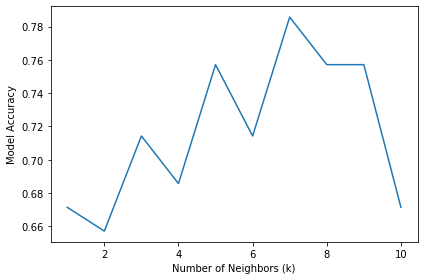

k = 7 yields the best accuracy (0.785714)


In [19]:
Ks = 10  # Number of neighbors to iterate
loan_knn_acc = np.zeros(Ks)  # Initiate an array

# Train model, predict y_hat, calculate accuracy
# for different values of k
for k in range(1,Ks+1):
    loan_knn = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    loan_knn_pred = loan_knn.predict(X_test)
    loan_knn_acc[k-1] = accuracy_score(y_test, loan_knn_pred)

# Plot k vs accuracy
plt.plot(range(1,Ks+1), loan_knn_acc)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Model Accuracy')
plt.tight_layout()
plt.show()
print(f'k = {loan_knn_acc.argmax()+1} yields '
      f'the best accuracy ({loan_knn_acc.max():.6f})')

In [20]:
# Compare y_test, y_hat at k = 7
loan_knn7 = KNeighborsClassifier(n_neighbors=7).fit(X_train, y_train)
loan_knn7_pred = loan_knn7.predict(X_test)
knn7_result = pd.DataFrame({
    'y_test':pd.Series(y_test),
    'y_hat':pd.Series(loan_knn7_pred)
})
knn7_result.head(12)

,y_test,y_hat
0,PAIDOFF,PAIDOFF
1,PAIDOFF,PAIDOFF
2,PAIDOFF,PAIDOFF
3,PAIDOFF,PAIDOFF
4,PAIDOFF,PAIDOFF
5,PAIDOFF,PAIDOFF
6,COLLECTION,COLLECTION
7,PAIDOFF,COLLECTION
8,PAIDOFF,PAIDOFF
9,PAIDOFF,PAIDOFF


### Decision Tree

In [21]:
# Create a classifier instance, train the model
loan_tree = tree.DecisionTreeClassifier(
    criterion='entropy').fit(X_train, y_train)
loan_tree_pred = loan_tree.predict(X_test)

# Compare y_test, y_hat
tree_result = pd.DataFrame({
    'y_test':pd.Series(y_test),
    'y_hat':pd.Series(loan_tree_pred)
})
tree_result.head(12)

,y_test,y_hat
0,PAIDOFF,PAIDOFF
1,PAIDOFF,PAIDOFF
2,PAIDOFF,PAIDOFF
3,PAIDOFF,PAIDOFF
4,PAIDOFF,PAIDOFF
5,PAIDOFF,PAIDOFF
6,COLLECTION,COLLECTION
7,PAIDOFF,COLLECTION
8,PAIDOFF,PAIDOFF
9,PAIDOFF,PAIDOFF


Visualize the decision tree:

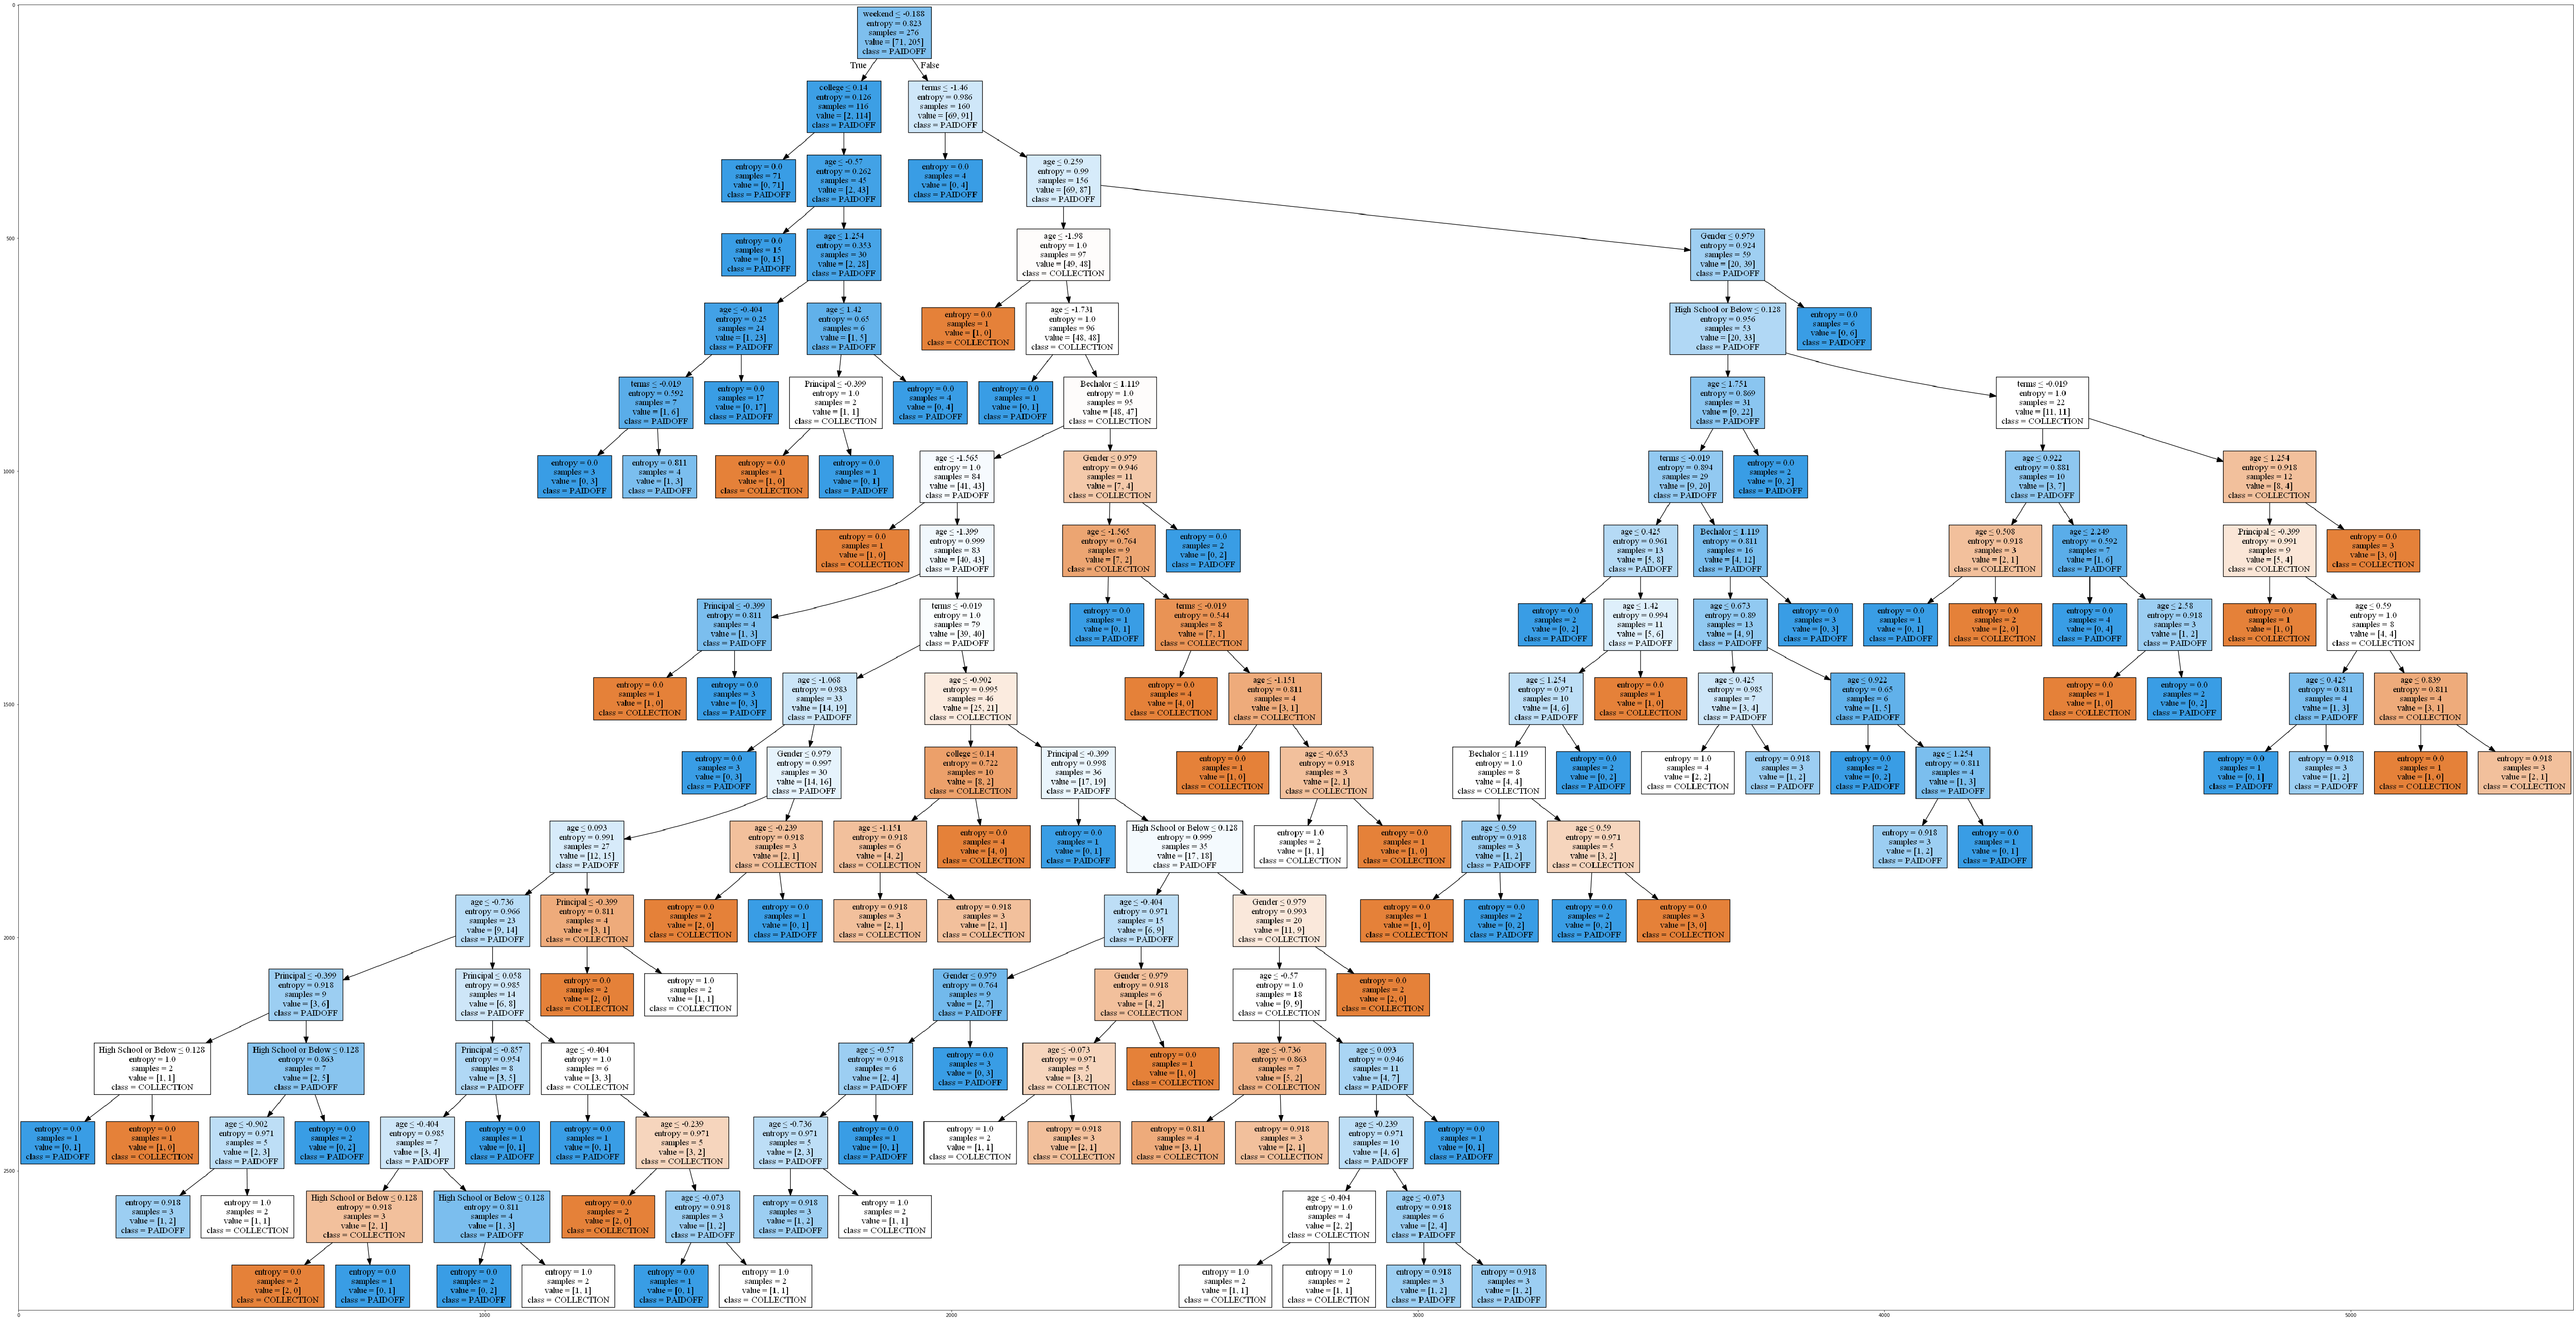

In [22]:
dot_data = StringIO()
filename = 'loan-decision-tree.png'
feature_names = features.columns
out = tree.export_graphviz(
    loan_tree,
    feature_names=feature_names,
    out_file=dot_data,
    class_names=np.unique(y_train),
    filled=True,
    special_characters=True,
    rotate=False)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img, interpolation='nearest')

### Support Vector Machine

Create SVM models using different kernel functions:

In [23]:
kernel_funcs = ['linear', 'poly', 'rbf', 'sigmoid']
print(f'SVM model accuracy for different kernel functions:')
for func in kernel_funcs:
    loan_svm = svm.SVC(kernel=func)
    loan_svm.fit(X_train, y_train)
    loan_svm_pred = loan_svm.predict(X_test)
    print(f'-{func}: {accuracy_score(y_test, loan_svm_pred):.6f}')

SVM model accuracy for different kernel functions:
-linear: 0.785714
-poly: 0.771429
-rbf: 0.742857
-sigmoid: 0.742857


The best accuracy was obtained by using the linear kernel.

In [24]:
loan_svm = svm.SVC(kernel='linear').fit(X_train, y_train)
loan_svm_pred = loan_svm.predict(X_test)
svm_result = pd.DataFrame({
    'y_test':pd.Series(y_test),
    'y_hat':pd.Series(loan_svm_pred)
})
svm_result.head(12)

,y_test,y_hat
0,PAIDOFF,PAIDOFF
1,PAIDOFF,PAIDOFF
2,PAIDOFF,PAIDOFF
3,PAIDOFF,PAIDOFF
4,PAIDOFF,PAIDOFF
5,PAIDOFF,PAIDOFF
6,COLLECTION,PAIDOFF
7,PAIDOFF,PAIDOFF
8,PAIDOFF,PAIDOFF
9,PAIDOFF,PAIDOFF


### Logistic Regression

In [25]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
print(f'LR model accuracy for different solvers:')
for solver in solvers:
    loan_lr = LogisticRegression(C=0.1, solver=solver)
    loan_lr.fit(X_train, y_train)
    loan_lr_pred = loan_lr.predict(X_test)
    print(f'-{solver}: {accuracy_score(y_test, loan_lr_pred):.6f}')

LR model accuracy for different solvers:
-newton-cg: 0.771429
-lbfgs: 0.771429
-liblinear: 0.742857
-sag: 0.771429
-saga: 0.771429


In [26]:
loan_lr = LogisticRegression(
    C=0.1, solver='liblinear').fit(X_train, y_train)
loan_lr_pred = loan_lr.predict(X_test)
lr_proba = pd.DataFrame(
    loan_lr.predict_proba(X_test),
    columns=['p(COLLECTION)', 'p(PAIDOFF)']
)
lr_proba.head(12)

,p(COLLECTION),p(PAIDOFF)
0,0.510250,0.489750
1,0.402951,0.597049
2,0.097982,0.902018
3,0.128030,0.871970
4,0.098982,0.901018
5,0.108726,0.891274
6,0.466786,0.533214
7,0.438048,0.561952
8,0.128030,0.871970
9,0.476326,0.523674


## Model Evaluation using Test Set

### Load Test Data

In [27]:
loan_test = 'https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv'
test_df = pd.read_csv(loan_test)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


### Pre-processing

Perform similar pre-processing that was previously done on training data.

In [28]:
# Remove irrelevant columns
test_df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

# Datetime conversion
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['due_date'] = pd.to_datetime(test_df['due_date'])

# New field: the day people get loan
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

# New field: evaluate whether weekend (1) or not (0)
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3) else 0)

# One-hot encoding for gender
test_df['Gender'].replace(
    to_replace=['male','female'], value=[0,1], inplace=True)

# Select features from test data
test_features = test_df[[
    'Principal',
    'terms',
    'age',
    'Gender',
    'weekend',
]]

# One-hot encoding for education levels
test_features = pd.concat(
    [test_features, pd.get_dummies(test_df['education'])], axis=1)
test_features.drop('Master or Above', axis=1, inplace=True)

# Feature normalization
scaler = preprocessing.StandardScaler()
test_X = scaler.fit(test_features).transform(test_features)

# Define class labels
test_y = test_df['loan_status'].values

### Evaluate models with different metrics

In [29]:
# KNN evaluation
pred_knn = loan_knn7.predict(test_X)
jac_knn = jaccard_score(test_y, pred_knn, pos_label='PAIDOFF')
f1_knn = f1_score(test_y, pred_knn, average='weighted')

# Decision Tree evaluation
pred_tree = loan_tree.predict(test_X)
jac_tree = jaccard_score(test_y, pred_tree, pos_label='PAIDOFF')
f1_tree = f1_score(test_y, pred_tree, average='weighted')

# SVM evaluation
pred_svm = loan_svm.predict(test_X)
jac_svm = jaccard_score(test_y, pred_svm, pos_label='PAIDOFF')
f1_svm = f1_score(test_y, pred_svm, average='weighted')

# Logistic Regression evaluation
pred_lr = loan_lr.predict(test_X)
jac_lr = jaccard_score(test_y, pred_lr, pos_label='PAIDOFF')
f1_lr = f1_score(test_y, pred_lr, average='weighted')  
loss_lr = log_loss(test_y, loan_lr.predict_proba(test_X))

## Report
Report the accuracy of the built model using different evaluation metrics:

In [30]:
report = pd.DataFrame({
    'Jaccard':[jac_knn, jac_tree, jac_svm, jac_lr],
    'F1-Score':[f1_knn, f1_tree, f1_svm, f1_lr],
    'LogLoss':['NA', 'NA', 'NA', loss_lr]
},
    index = ['KNN', 'Decision Tree', 'SVM', 'Logistic Regression']
)
report.columns.name = 'Algorithm'
report

Algorithm,Jaccard,F1-Score,LogLoss
KNN,0.653846,0.632840,NA
Decision Tree,0.680851,0.725253,NA
SVM,0.740741,0.630418,NA
Logistic Regression,0.754717,0.671764,0.477704


The best classifiers are Logistic Regression (by Jaccard score) and Decision Tree (by F1-Score).

Author: [Saeed Aghabozorgi](https://ca.linkedin.com/in/saeedaghabozorgi). Copyright &copy; 2018 [Cognitive Class](https://cocl.us/DX0108EN_CC). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).